# Datathon_길잃은 오리들 프로덕션
## 데이터 확인, 삭제 및 

In [1]:
import re, os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold import MDS
from datetime import datetime

os.chdir("/home/technocracy90/Datathon")

print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

2024-12-08 21:38:57.372297: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-08 21:38:57.382279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733661537.393769   19748 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733661537.396755   19748 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 21:38:57.407400: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

2.18.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Kaggle 데이터 다운로드
import kagglehub
netflix_path = kagglehub.dataset_download("shivamb/netflix-shows")
amazon_path = kagglehub.dataset_download("shivamb/amazon-prime-movies-and-tv-shows")
disney_path = kagglehub.dataset_download("shivamb/disney-movies-and-tv-shows")

# 저장된 경로 확인
print(netflix_path)
print(amazon_path)
print(disney_path)

# cash 디렉토리에서 작업 디렉토리로 복사
from distutils.dir_util import copy_tree
root_path = os.path.join(os.getenv('HOME'), 'Datathon')
copy_tree(netflix_path, root_path)
copy_tree(amazon_path, root_path)
copy_tree(disney_path, root_path)

# 데이터 경로 업데이트

def update_path(data_path):
    name = data_path.split("/")[-3]
    name = name.split("-")[0]

    for file in os.listdir(root_path):
        filename, extension = os.path.splitext(file)
        filename = filename.split("_")[0]
        if extension == ".csv" and name == filename:
            return  os.path.join(root_path, file)

netflix_path = update_path(netflix_path)
amazon_path = update_path(amazon_path)
disney_path = update_path(disney_path)

# 저장된 경로 확인
print(netflix_path)
print(amazon_path)
print(disney_path)

/home/technocracy90/.cache/kagglehub/datasets/shivamb/netflix-shows/versions/5
/home/technocracy90/.cache/kagglehub/datasets/shivamb/amazon-prime-movies-and-tv-shows/versions/1
/home/technocracy90/.cache/kagglehub/datasets/shivamb/disney-movies-and-tv-shows/versions/2
/home/technocracy90/Datathon/netflix_titles.csv
/home/technocracy90/Datathon/amazon_prime_titles.csv
/home/technocracy90/Datathon/disney_plus_titles.csv


In [3]:
# 데이터 적재
netflix = pd.read_csv(netflix_path)
amazon = pd.read_csv(amazon_path)
disney = pd.read_csv(disney_path)

In [4]:
# 분석하지 않을 컬럼 드랍
netflix = netflix.drop(columns=["title", "cast", "director", "duration"])
amazon = amazon.drop(columns=["title", "cast", "director", "duration"])
disney = disney.drop(columns=["title", "cast", "director", "duration"])

In [5]:
#id 패딩 함수
def pad_show_id(show_id):
    pattern = re.compile(r"s(\d+)")
    result = pattern.sub(lambda match: f"s{int(match.group(1)):04d}", show_id)
    return result

netflix['show_id'] = netflix['show_id'].apply(pad_show_id)
amazon['show_id'] = amazon['show_id'].apply(pad_show_id)
disney['show_id'] = disney['show_id'].apply(pad_show_id)

print(netflix.info())
print(amazon.info())
print(disney.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   country       7976 non-null   object
 3   date_added    8797 non-null   object
 4   release_year  8807 non-null   int64 
 5   rating        8803 non-null   object
 6   listed_in     8807 non-null   object
 7   description   8807 non-null   object
dtypes: int64(1), object(7)
memory usage: 550.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9668 entries, 0 to 9667
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       9668 non-null   object
 1   type          9668 non-null   object
 2   country       672 non-null    object
 3   date_added    155 non-null    object
 4   release_year  9668 non-null   int64 
 5   rating      

In [6]:
# 'type' 컬럼 인코딩
netflix['type'] = pd.get_dummies(netflix['type'], drop_first=True, dtype = 'int')
netflix.rename(columns = {'type' : 'TV Show'}, inplace = True)

disney['type'] = pd.get_dummies(disney['type'], drop_first=True, dtype = 'int')
disney.rename(columns = {'type' : 'TV Show'}, inplace = True)

amazon['type'] = pd.get_dummies(amazon['type'], drop_first=True, dtype = 'int')
amazon.rename(columns = {'type' : 'TV Show'}, inplace = True)

In [7]:
# datetime으로 변환 함수
def date_and_time(dataframe):
    dataframe['date_added'] = dataframe['date_added'].astype('str')
    dataframe['release_year'] = dataframe['release_year'].astype('str')
    counter_release = 0
    counter_added = 0
    
    for entry, index in zip(dataframe['release_year'], dataframe.index):
        if type(entry) != datetime:
            try:
                dataframe.at[index, 'release_year'] = datetime.strptime(str(entry), "%Y")
            except Exception as e:
                counter_release += 1
                print(f"{e}:\n{index}, {entry}")

    
    for entry, index in zip(dataframe['date_added'], dataframe.index):
        try:
            dataframe.at[index, 'date_added'] = datetime.strptime(entry.lstrip(), "%B %d, %Y")
        except Exception as e:
            counter_added += 1
            dataframe.at[index, 'date_added'] = dataframe.at[index, 'release_year']
    
    print(f'{counter_release} release_dates have not converted!')
    print(f'{counter_added} date_added were missing!')

In [8]:
date_and_time(netflix)
date_and_time(amazon)
date_and_time(disney)

0 release_dates have not converted!
10 date_added were missing!
0 release_dates have not converted!
9513 date_added were missing!
0 release_dates have not converted!
3 date_added were missing!


In [9]:
# Y년 이후의 데이터포인트만 추출하는 함수
def slice_release_year(dataframe, year):
    temp = dataframe[dataframe["release_year"] > datetime.strptime(year, "%Y")]
    temp = temp.reset_index(drop=True)
    
    return temp

In [10]:
# date_added와 release_year의 차이를 added_delay 컬럼으로 생성 및 출시연도별 지연일 평균 출력
netflix['added_delay'] = netflix['date_added'] - netflix['release_year']
print(netflix.groupby(['release_year'])['added_delay'].mean())

disney['added_delay'] = disney['date_added'] - disney['release_year']
print(disney.groupby(['release_year'])['added_delay'].mean())

# amazon 데이터셋은 date_added 항목의 결측치가 너무 많아 분석에서 제외
# amazon['added_delay'] = amazon['date_added'] - amazon['release_year']
# print(amazon.groupby(['release_year'])['added_delay'].mean())

release_year
1925-01-01            34331 days 00:00:00
1942-01-01            27483 days 00:00:00
1943-01-01            27118 days 00:00:00
1944-01-01            26753 days 00:00:00
1945-01-01            26739 days 18:00:00
                         ...             
2017-01-01    582 days 23:08:22.325581392
2018-01-01    461 days 23:24:50.845684392
2019-01-01    355 days 09:13:37.864077668
2020-01-01    253 days 00:31:43.882476392
2021-01-01    149 days 00:19:27.567567568
Name: added_delay, Length: 74, dtype: object
release_year
1928-01-01             33553 days 00:00:00
1932-01-01             32092 days 00:00:00
1933-01-01             31726 days 00:00:00
1934-01-01             31361 days 00:00:00
1935-01-01             31031 days 18:00:00
                          ...             
2017-01-01    1205 days 14:57:23.478260864
2018-01-01     898 days 08:29:32.307692304
2019-01-01     502 days 17:27:16.363636360
2020-01-01     310 days 17:41:03.157894736
2021-01-01        213 days 22:39:21.6

In [11]:
def release_added_corr(dataframe):
    subframe = dataframe[['date_added', 'release_year']]
    subframe['date_added'] = subframe['date_added'].apply(lambda x: x.strftime('%Y%m%d'))
    subframe['release_year'] = subframe['release_year'].apply(lambda x: x.strftime('%Y'))

    return subframe.corr(), subframe

release_added_corr(netflix)

/tmp/ipykernel_19748/647202298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subframe['date_added'] = subframe['date_added'].apply(lambda x: x.strftime('%Y%m%d'))
/tmp/ipykernel_19748/647202298.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subframe['release_year'] = subframe['release_year'].apply(lambda x: x.strftime('%Y'))


(              date_added  release_year
 date_added      1.000000      0.112798
 release_year    0.112798      1.000000,
      date_added release_year
 0      20210925         2020
 1      20210924         2021
 2      20210924         2021
 3      20210924         2021
 4      20210924         2021
 ...         ...          ...
 8802   20191120         2007
 8803   20190701         2018
 8804   20191101         2009
 8805   20200111         2006
 8806   20190302         2015
 
 [8807 rows x 2 columns])

In [12]:
def release_added_corr_cumulative(dataframe):
    subframe = release_added_corr(dataframe)[1]

    subframe['date_added'] = dataframe['date_added'].astype(str).str[0:4]
    subframe = subframe.sort_values(by=['release_year'])
    
    returnframe = pd.DataFrame(subframe['release_year'].unique(), columns=["release_year"])
    temp = []

    for year in returnframe['release_year']:
        temp1 = subframe[subframe["release_year"] >= year]
        temp.append(temp1.corr()['release_year']['date_added'])

    returnframe['release_delay_corr'] = temp
    return returnframe.corr(), returnframe

print(release_added_corr_cumulative(netflix))
print(release_added_corr_cumulative(disney))

(                    release_year  release_delay_corr
release_year            1.000000            0.768659
release_delay_corr      0.768659            1.000000,    release_year  release_delay_corr
0          1925            0.113208
1          1942            0.113250
2          1943            0.111958
3          1944            0.110002
4          1945            0.108022
..          ...                 ...
69         2017            0.772389
70         2018            0.772266
71         2019            0.776809
72         2020            0.788024
73         2021                 NaN

[74 rows x 2 columns])
(                    release_year  release_delay_corr
release_year            1.000000            0.751648
release_delay_corr      0.751648            1.000000,    release_year  release_delay_corr
0          1928            0.317689
1          1932            0.317222
2          1933            0.315708
3          1934            0.314161
4          1935            0.312052
..    

/tmp/ipykernel_19748/647202298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subframe['date_added'] = subframe['date_added'].apply(lambda x: x.strftime('%Y%m%d'))
/tmp/ipykernel_19748/647202298.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subframe['release_year'] = subframe['release_year'].apply(lambda x: x.strftime('%Y'))
/tmp/ipykernel_19748/1277830221.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/tmp/ipykernel_19748/647202298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subframe['date_added'] = subframe['date_added'].apply(lambda x: x.strftime('%Y%m%d'))
/tmp/ipykernel_19748/647202298.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subframe['release_year'] = subframe['release_year'].apply(lambda x: x.strftime('%Y'))
/tmp/ipykernel_19748/1277830221.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

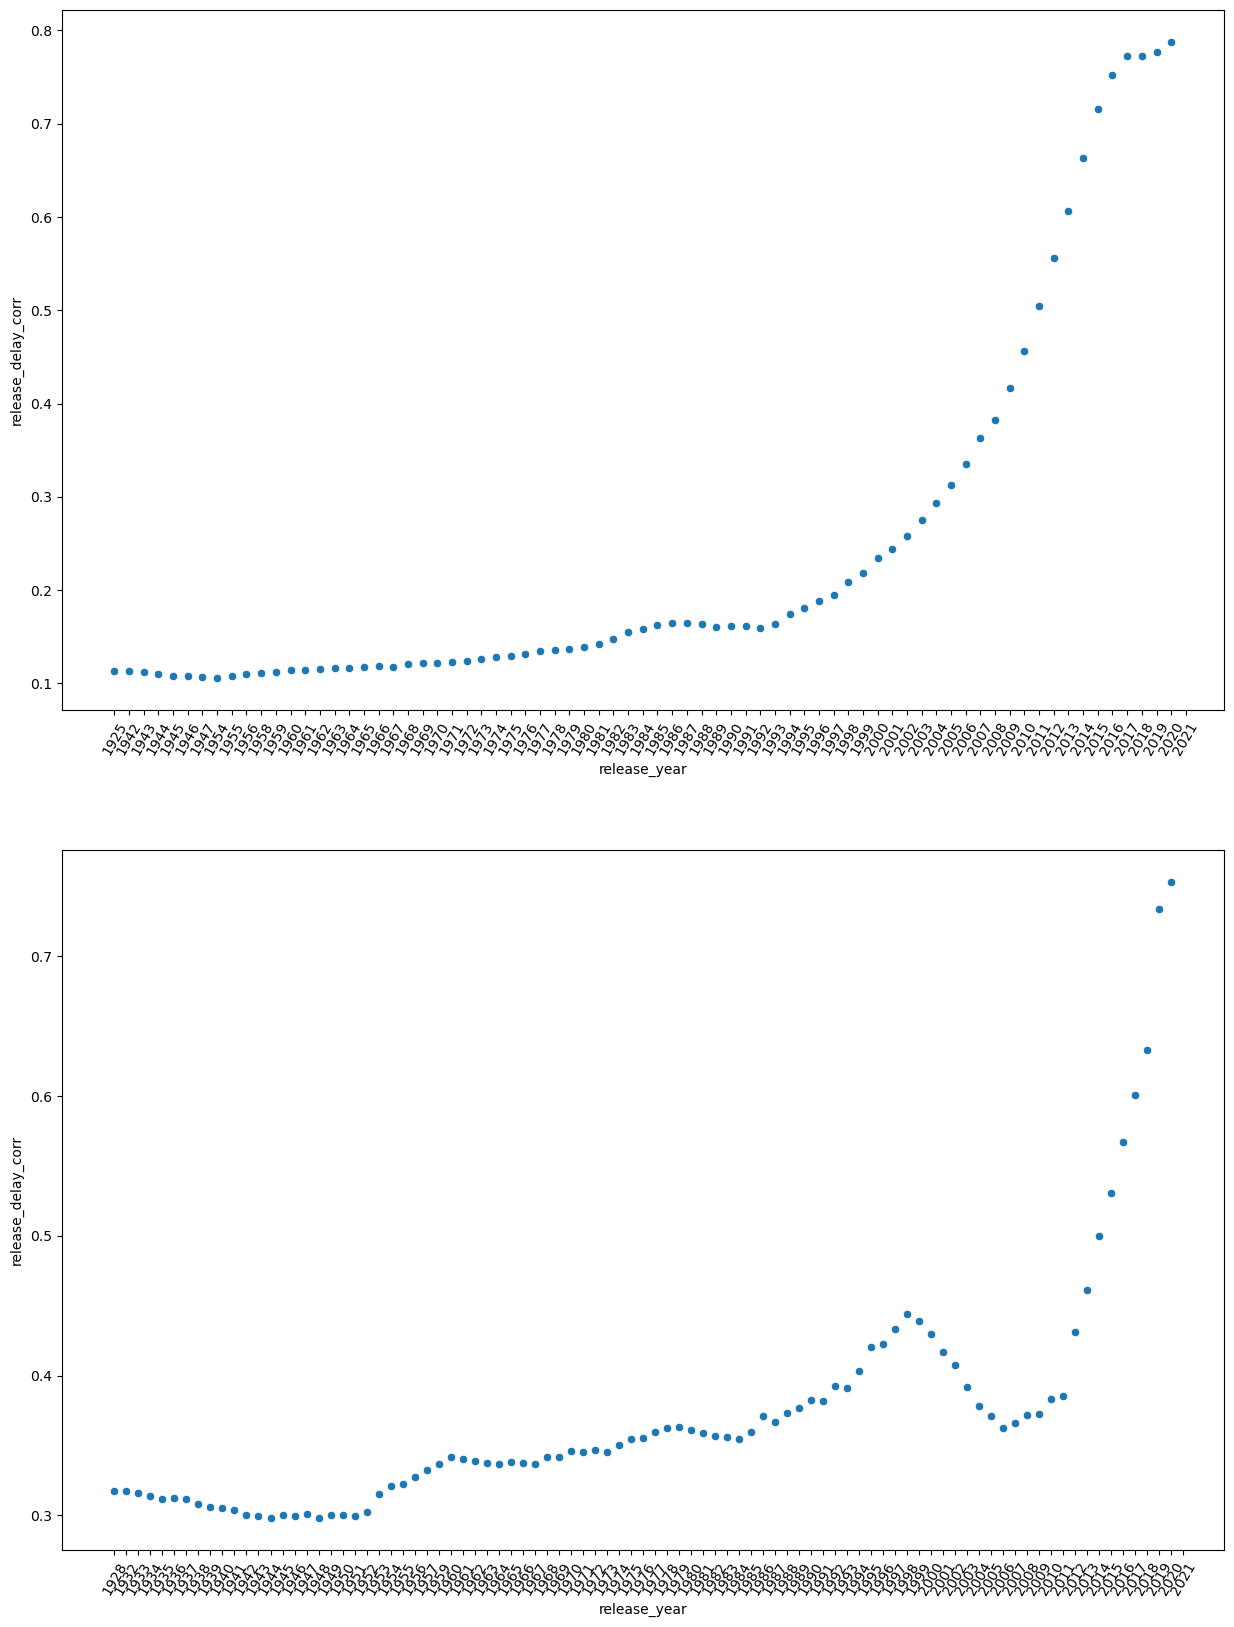

In [13]:
fig = plt.figure(figsize=(15,20))

ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.tick_params(axis='x', labelrotation=60)
ax2.tick_params(axis='x', labelrotation=60)

netflix_plot = release_added_corr_cumulative(netflix)[1]
sns.scatterplot(data = netflix_plot, x=netflix_plot['release_year'], y=netflix_plot['release_delay_corr'], ax= ax1)

disney_plot = release_added_corr_cumulative(disney)[1]
sns.scatterplot(data = disney_plot, x=disney_plot['release_year'], y=disney_plot['release_delay_corr'], ax = ax2)

plt.show()

In [14]:
# sns.boxplot(data = netflix, x = netflix["release_year"], y = netflix["date_added"])

In [15]:
netflix_recent = slice_release_year(netflix, "2017")
amazon_recent = slice_release_year(amazon, "2017")
disney_recent = slice_release_year(disney, "2017")

In [16]:
a = netflix_recent[['date_added', 'release_year']]
a['date_added'] = a['date_added'].apply(lambda x: x.strftime('%Y%m%d'))
a['release_year'] = a['release_year'].apply(lambda x: x.strftime('%Y%m%d'))
a = a.astype(int)
a.corr()

/tmp/ipykernel_19748/3253408774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['date_added'] = a['date_added'].apply(lambda x: x.strftime('%Y%m%d'))
/tmp/ipykernel_19748/3253408774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['release_year'] = a['release_year'].apply(lambda x: x.strftime('%Y%m%d'))


date_added  release_year
date_added      1.000000      0.774645
release_year    0.774645      1.000000

In [17]:
# ","으로 나누어진 문자열 변수를 나누고, 필요에 따라 재분류하고, 인코딩하는 함수
def split_and_encode(dataframe, column, replace_dict = {}):
    mlb = MultiLabelBinarizer()
    temp = dataframe[column].str.split(",", expand = True)

    for i in range(temp.shape[1]):
        temp[i] = temp[i].apply(lambda x: str(x).lstrip()) # it also converts "None" to str

    if replace_dict:
        temp.replace(replace_dict, inplace = True)

    temp = pd.DataFrame(mlb.fit_transform(temp.values.tolist()), columns=mlb.classes_)
    temp.drop(["None"], axis=1, inplace = True)

    try:
        temp.drop([""], axis = 1, inplace = True)
    except:
        pass
    
    try:
        temp.drop(["nan"], axis = 1, inplace = True)
    except:
        pass

    dataframe[column] = temp.sum(axis=1)

    return temp

def read_replace_map(filename):
    replace_dict = {}

    with open(filename, 'r') as file:
        lines = file.readlines()

    for line in lines:
        key,value = line.strip().split(" = ")
        replace_dict[key.strip("'")] = value.strip("'")

    return replace_dict

In [18]:
netflix_recent_country = split_and_encode(netflix_recent, "country")
amazon_recent_country = split_and_encode(amazon_recent, "country")
disney_recent_country = split_and_encode(disney_recent, "country")

netflix_recent = pd.concat([netflix_recent, netflix_recent_country], axis=1)
amazon_recent = pd.concat([amazon_recent, amazon_recent_country], axis=1)
disney_recent = pd.concat([disney_recent, disney_recent_country], axis=1)

In [19]:
replace_map = read_replace_map('listed_in_replace_map.txt')
print(replace_map)

netflix_recent_genre = split_and_encode(netflix_recent, "listed_in", replace_map)
amazon_recent_genre = split_and_encode(amazon_recent, "listed_in", replace_map)
disney_recent_genre = split_and_encode(disney_recent, "listed_in", replace_map)

netflix_recent = pd.concat([netflix_recent, netflix_recent_genre], axis=1)
amazon_recent = pd.concat([amazon_recent, disney_recent_genre], axis=1)
disney_recent = pd.concat([disney_recent, amazon_recent_genre], axis=1)

{'Anime Features': 'Animation', 'Anime Series': 'Animation', 'Classic & Cult TV': 'Crime/Mystery/Thriller', 'Classic Movies': 'Classic', 'Crime TV Shows': 'Crime/Mystery/Thriller', 'Cult Movies': 'Crime/Mystery/Thriller', 'Documentaries': 'Documentary', 'Docuseries': 'Documentary', 'Faith & Spirituality': 'Drama', 'Horror Movies': 'Crime/Mystery/Thriller', 'Independent Movies': 'Independent', 'International Movies': 'International', 'International TV Shows': 'International', "Kids' TV": 'Family', 'LGBTQ Movies': 'Romance', 'Romantic Movies': 'Romance', 'Romantic TV Shows': 'Romance', 'Science & Nature TV': 'Documentary', 'Sports Movies': 'Action/Adventure', 'Stand-Up Comedy & Talk Shows': 'Comedy', 'TV Action & Adventure': 'Action/Adventure', 'TV Comedies': 'Comedy', 'TV Dramas': 'Drama', 'TV Horror': 'Crime/Mystery/Thriller', 'TV Mysteries': 'Crime/Mystery/Thriller', 'TV Sci-Fi & Fantasy': 'Sci-Fi/Fantasy', 'TV Thrillers': 'Crime/Mystery/Thriller', 'Arthouse': 'Drama', 'Faith and Spir

In [20]:
# csv로 출력
netflix_recent.to_csv(os.path.join(root_path, "netflixEDA_recent.csv"))
amazon_recent.to_csv(os.path.join(root_path, "amazonEDA_recent.csv"))
disney_recent.to_csv(os.path.join(root_path, "disneyEDA_recent.csv"))

/tmp/ipykernel_19748/218754254.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(labels = netflix_recent_genre.columns, rotation = 30)


<function matplotlib.pyplot.show(close=None, block=None)>

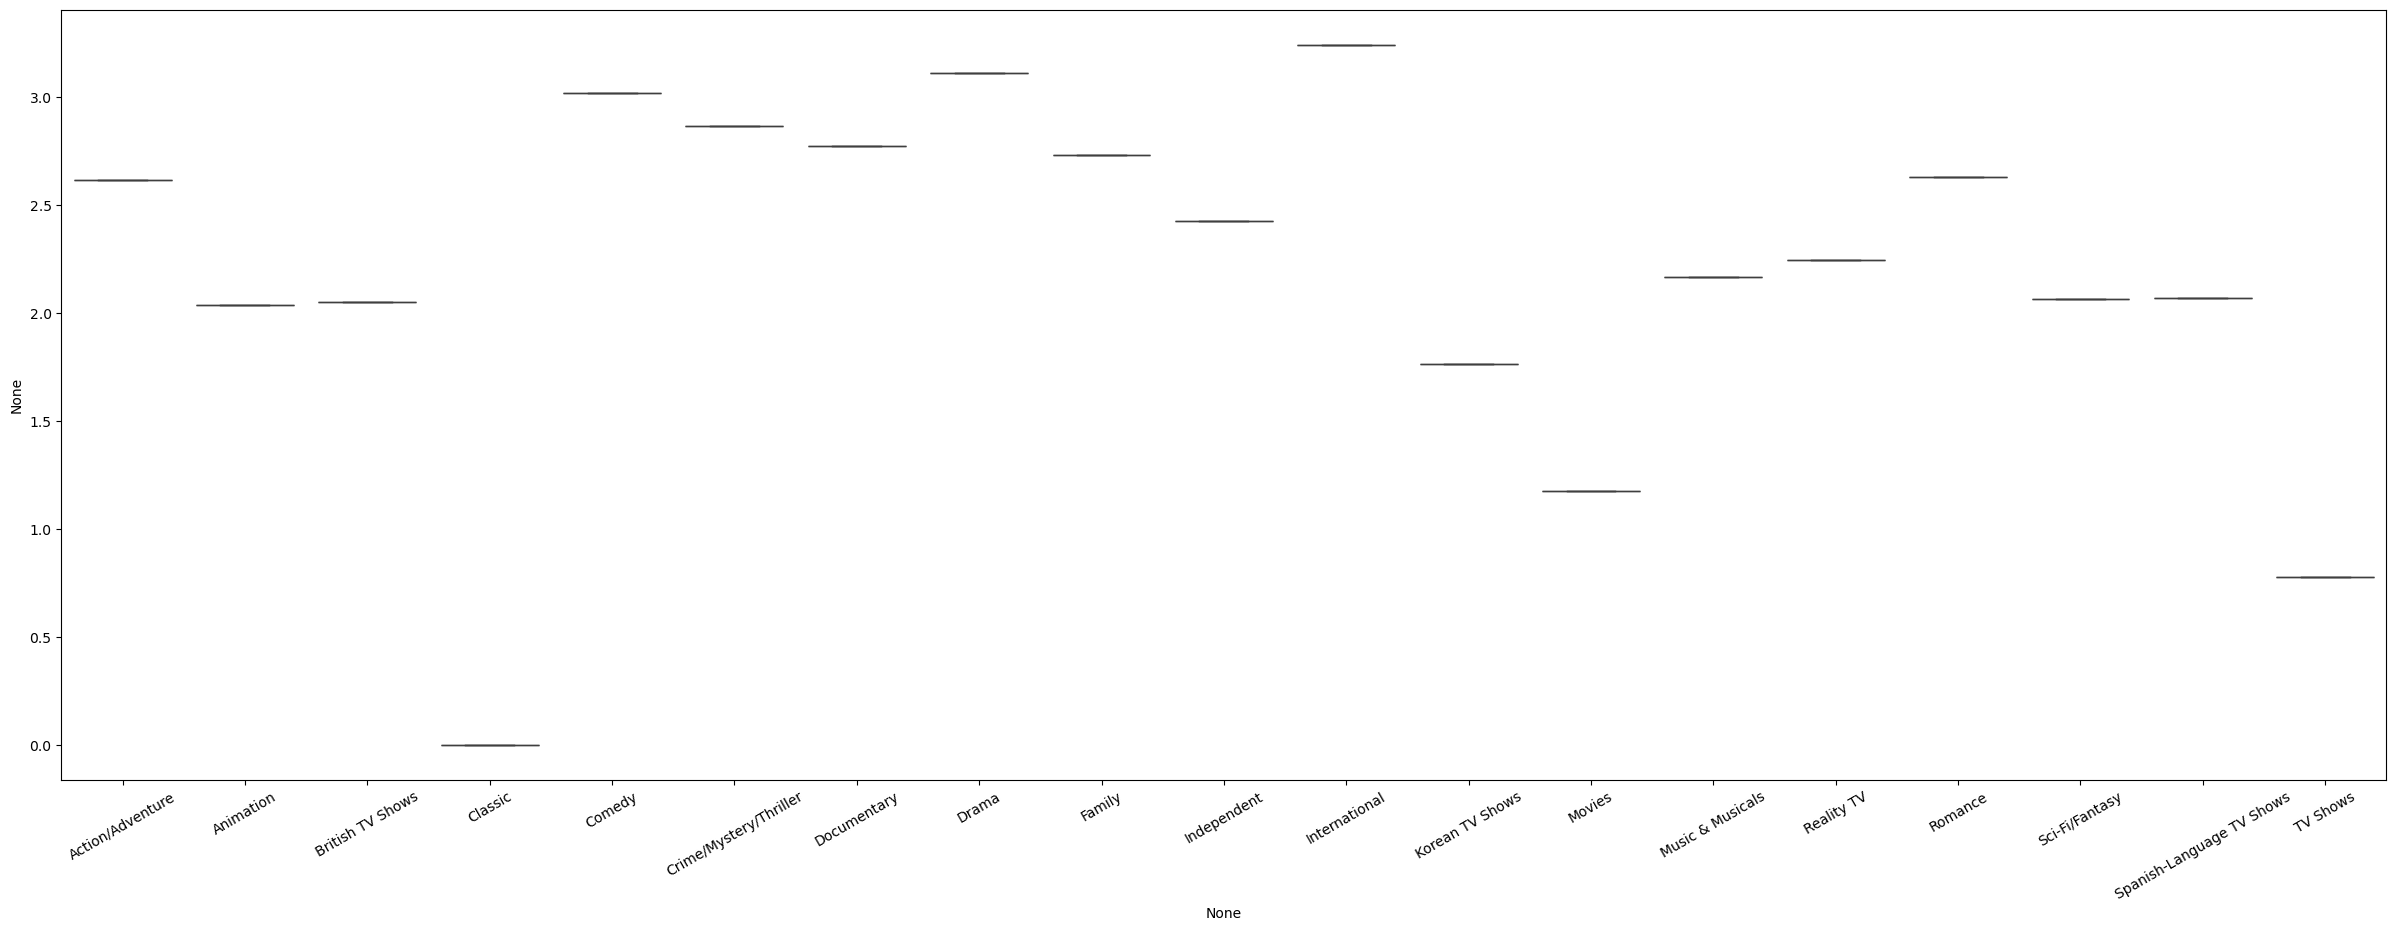

In [21]:
plt.figure(figsize=(30,10))
g = sns.boxplot(x = netflix_recent_genre.columns, y = np.log10(netflix_recent_genre.sum()))
g.set_xticklabels(labels = netflix_recent_genre.columns, rotation = 30)
plt.show

In [22]:
# 해당 기간 중 배급된 컨텐츠의 양을 기준으로 relevant한 국가들을 추출
netflix_recent_country_relevant = netflix_recent_country[netflix_recent_country.sum()[netflix_recent_country.sum() > 25].index]
amazon_recent_country_relevant = amazon_recent_country[amazon_recent_country.sum()[amazon_recent_country.sum() > 0].index]
disney_recent_country_relevant = disney_recent_country[disney_recent_country.sum()[disney_recent_country.sum() > 0].index]


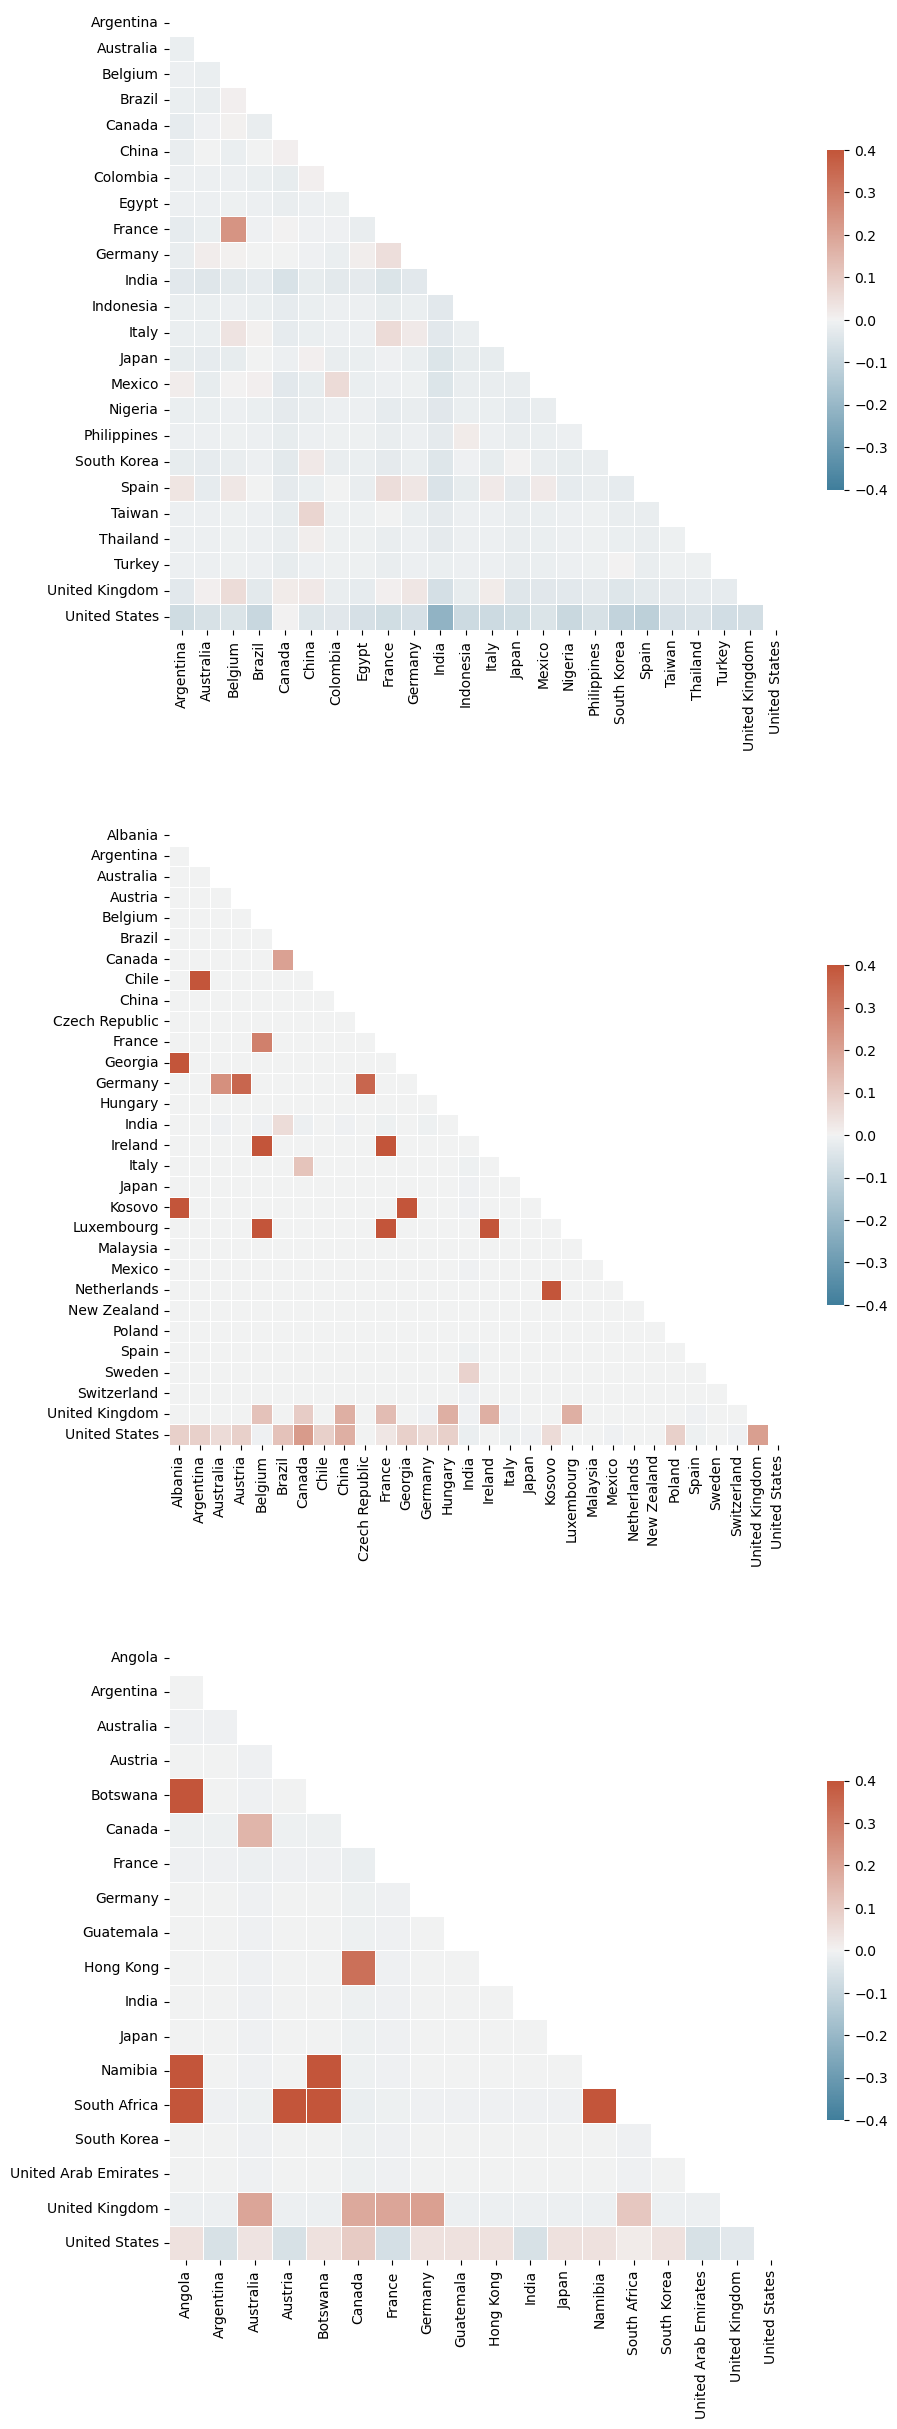

In [23]:
netflix_corr = netflix_recent_country_relevant.corr()
netflix_mask = np.triu(np.ones_like(netflix_corr, dtype=bool))

amazon_corr = amazon_recent_country_relevant.corr()
amazon_mask = np.triu(np.ones_like(amazon_corr, dtype=bool))

disney_corr = disney_recent_country_relevant.corr()
disney_mask = np.triu(np.ones_like(disney_corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

vmin = -0.4
vmax = 0.4

fig = plt.figure(figsize = (10, 30))
ax_netflix = fig.add_subplot(3, 1, 1)
ax_amazon = fig.add_subplot(3, 1, 2)
ax_disney = fig.add_subplot(3, 1, 3)

sns.heatmap(netflix_corr, mask=netflix_mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": .5}, vmin = vmin, vmax = vmax, ax = ax_netflix)
sns.heatmap(amazon_corr, mask=amazon_mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": .5}, vmin = vmin, vmax = vmax, ax = ax_amazon)
sns.heatmap(disney_corr, mask=disney_mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": .5}, vmin = vmin, vmax = vmax, ax = ax_disney)

plt.show()

In [24]:
netflix_recent_country_relevant

Argentina  Australia  Belgium  Brazil  Canada  China  Colombia  Egypt  \
0             0          0        0       0       0      0         0      0   
1             0          0        0       0       0      0         0      0   
2             0          0        0       0       0      0         0      0   
3             0          0        0       0       0      0         0      0   
4             0          0        0       0       0      0         0      0   
...         ...        ...      ...     ...     ...    ...       ...    ...   
3717          0          0        0       0       0      0         0      0   
3718          0          0        0       0       0      0         0      0   
3719          0          0        0       0       0      0         0      1   
3720          0          0        0       0       0      0         0      0   
3721          0          0        0       0       0      0         0      0   

      France  Germany  ...  Mexico  Nigeria  Philippines  South Korea  Spain  \
0          0        0  ...       0        0            0            0      0   
1          0        0  ...       0        0            0            0      0   
2          0        0  ...       0        0            0            0      0   
3          0        0  ...       0        0            0            0      0   
4          0        0  ...       0        0            0            0      0   
...      ...      ...  ...     ...      ...          ...          ...    ...   
3717       0        0  ...       0        0            0            0      0   
3718       0        0  ...       0        0            0            0      0   
3719       0        0  ...       0        0            0            0      0   
3720       0        0  ...       0        0            0            0      0   
3721       0        0  ...       0        0            0            0      0   

      Taiwan  Thailand  Turkey  United Kingdom  United States  
0          0         0       0               0              1  
1          0         0       0               0              0  
2          0         0       0               0              0  
3          0         0       0               0              0  
4          0         0       0               0              0  
...      ...       ...     ...             ...            ...  
3717       0         0       0               0              1  
3718       0         0       0               0              1  
3719       0         0       0               0              1  
3720       0         0       0               0              0  
3721       0         0       0               0              0  

[3722 rows x 24 columns]

/tmp/ipykernel_19748/4208747841.py:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method=link_method)


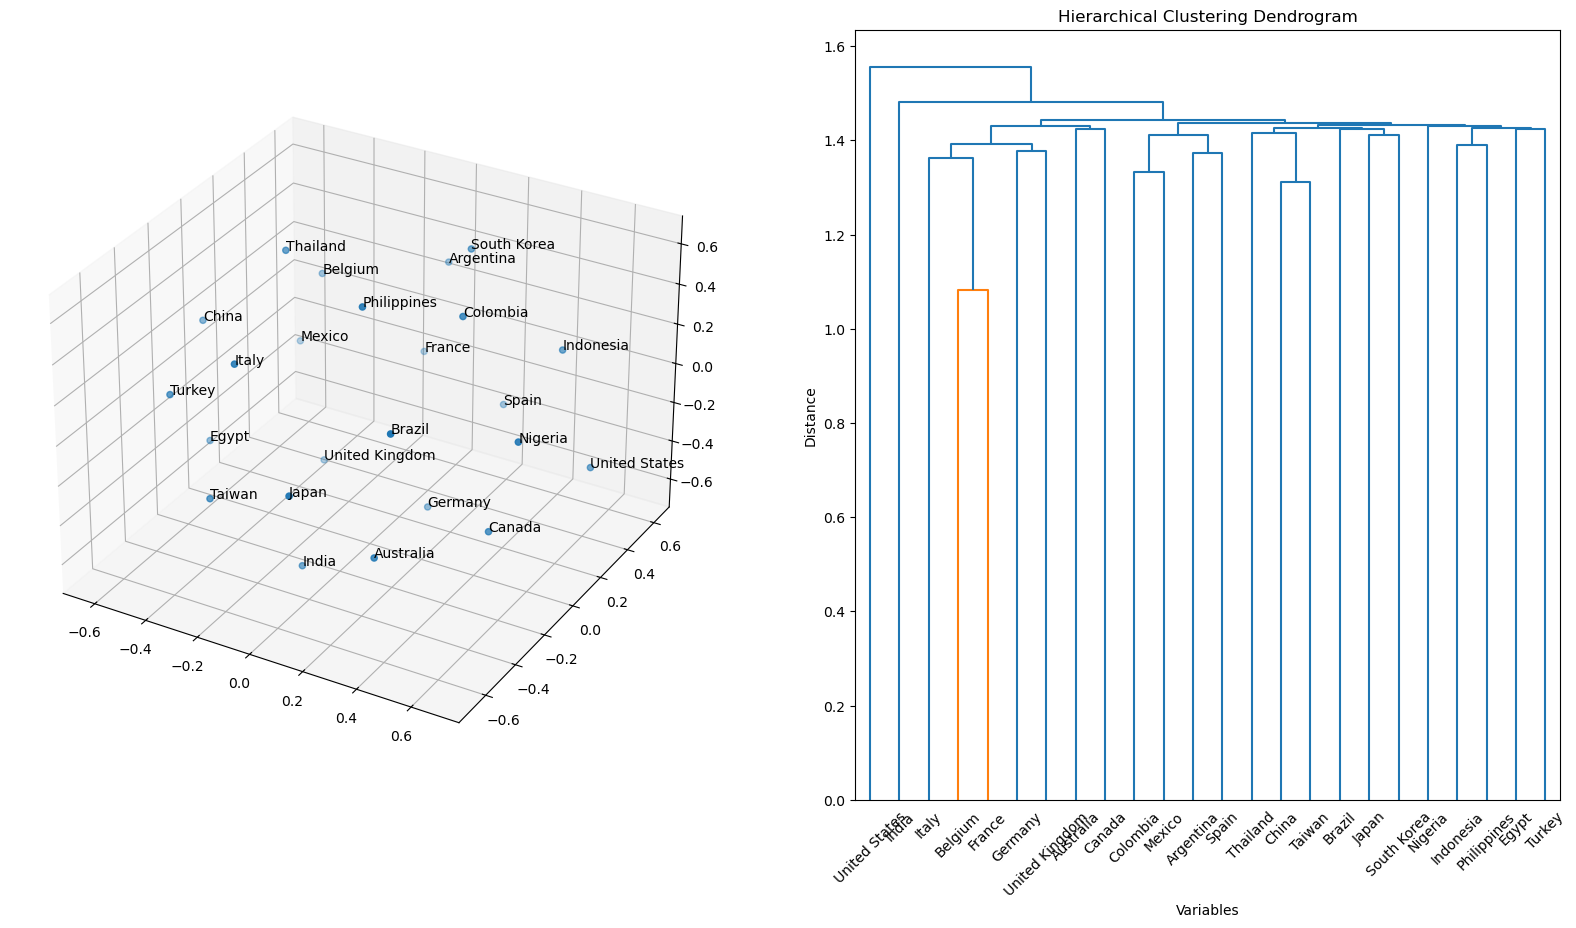

/tmp/ipykernel_19748/4208747841.py:6: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



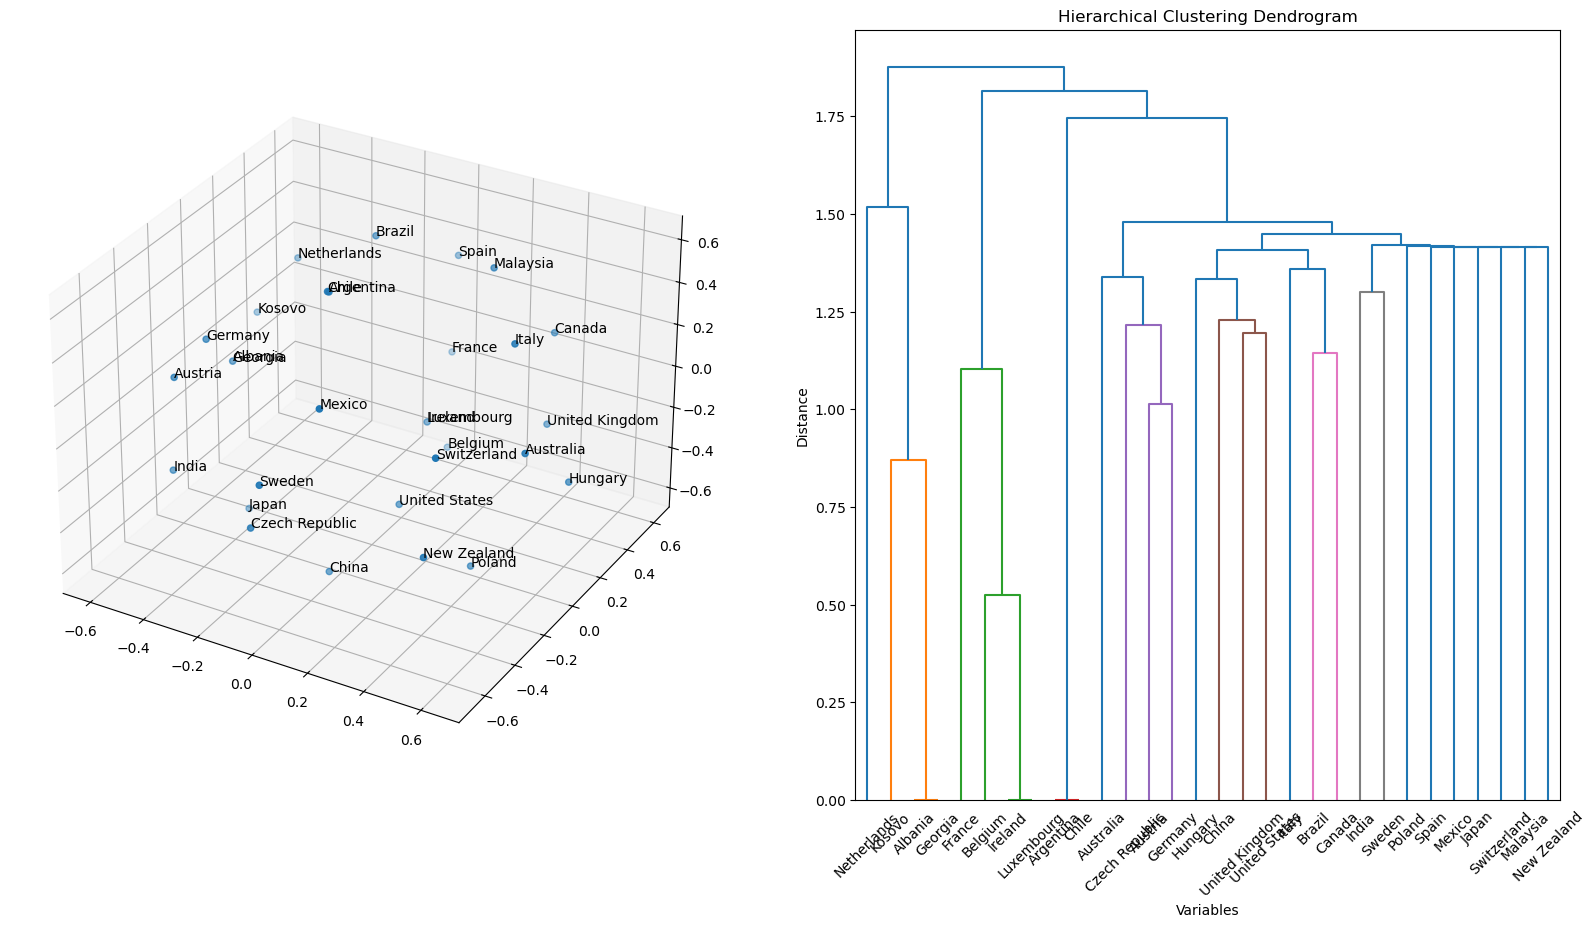

/tmp/ipykernel_19748/4208747841.py:6: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



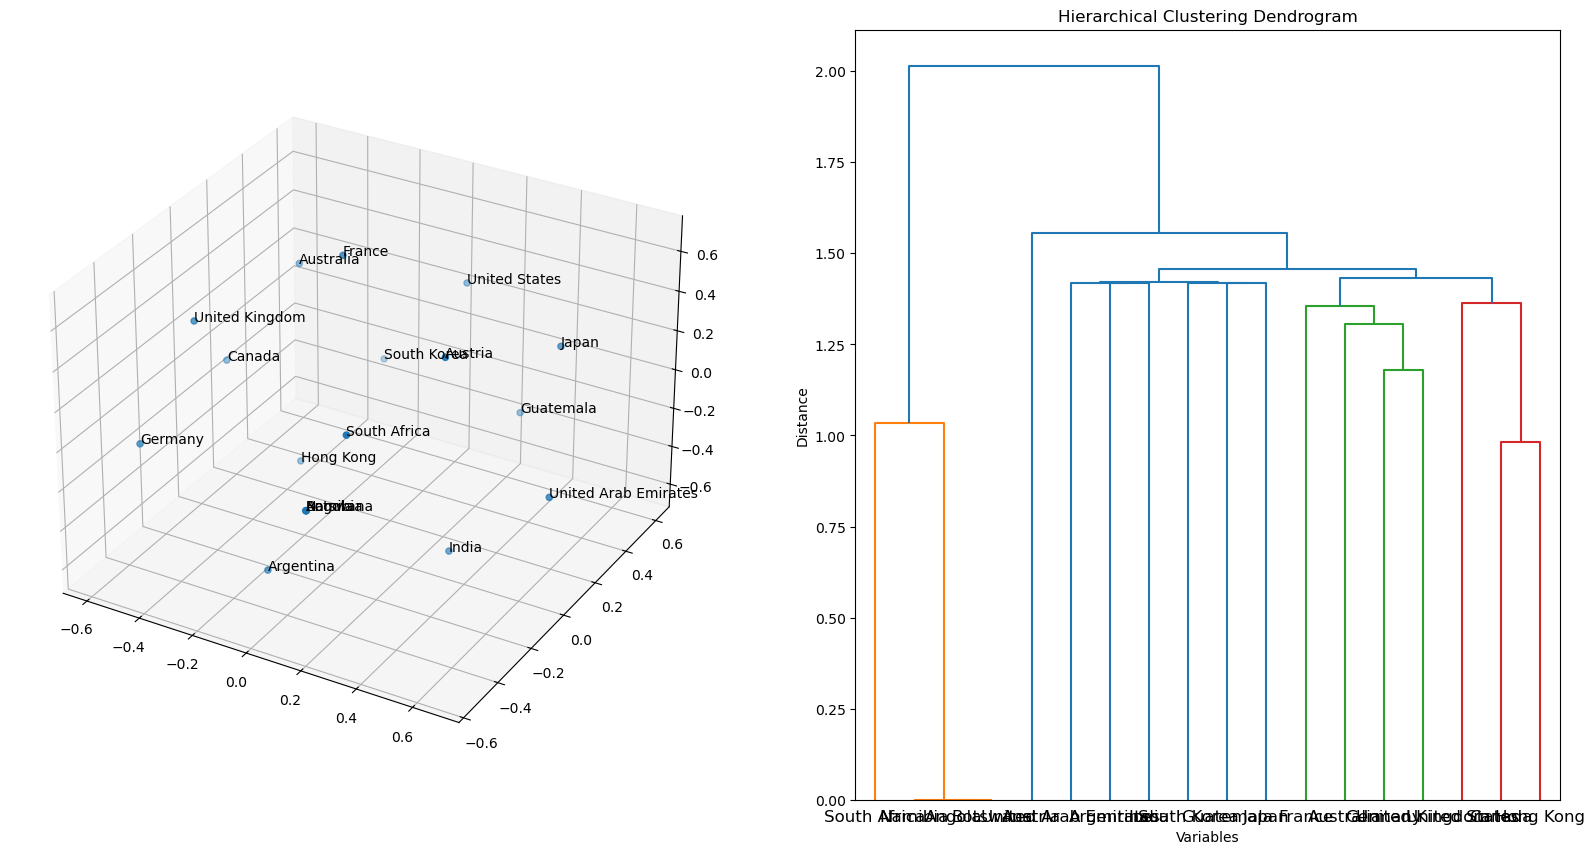

In [25]:
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

def h_clustering(correlation_matrix, link_method = "average"):
    distance_matrix = 1 - correlation_matrix
    linkage_matrix = sch.linkage(distance_matrix, method=link_method)
    
    mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
    mds_coords = mds.fit_transform(distance_matrix)
    
    mds_df = pd.DataFrame(mds_coords, columns=['MDS1', 'MDS2', 'MDS3'])
    mds_df['Variable'] = correlation_matrix.columns
    
    figure = plt.figure(figsize=(20, 10))
    ax1 = figure.add_subplot(1, 2, 1, projection="3d")
    ax2 = figure.add_subplot(1, 2, 2)
    
    ax1.scatter(mds_coords[:, 0], mds_coords[:, 1], mds_coords[:, 2])
    ax2 = sch.dendrogram(linkage_matrix, labels=distance_matrix.columns)
    
    for i, var in enumerate(correlation_matrix.columns):
        ax1.text(mds_coords[i, 0], mds_coords[i, 1], mds_coords[i, 2], var)
    
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Variables')
    plt.ylabel('Distance')
    plt.show()
    
    fig = px.scatter_3d(mds_df, x='MDS1', y='MDS2', z='MDS3', text='Variable', title='3D MDS Plot of Hierarchical Clustering')
    fig.update_traces(marker=dict(size=5)) # Show the plot fig.show()
    
    fig.show()
    
    

h_clustering(netflix_corr)
h_clustering(amazon_corr)
h_clustering(disney_corr)


Chi2 Statistic: 5865.542155597988
P-value: 0.0
There is a significant association between genres and countries.


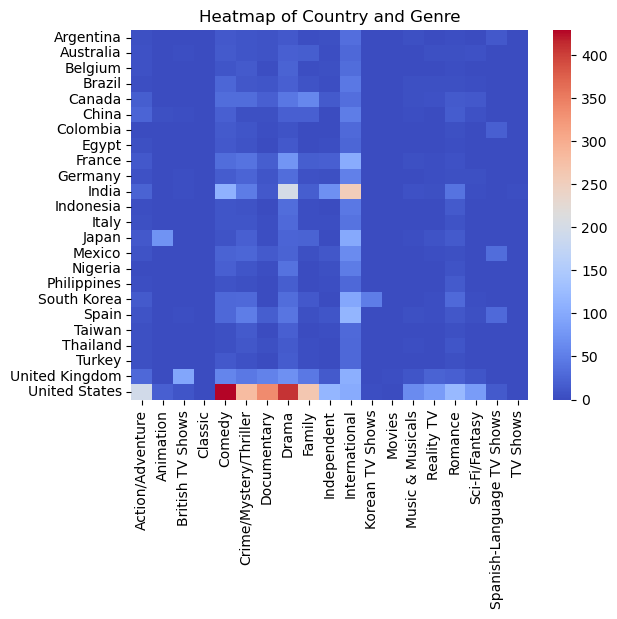

array([[6.06948061e+00, 1.53638482e+00, 1.84061943e+00, 3.04234617e-02,
        1.42533918e+01, 1.10285049e+01, 8.06221735e+00, 1.86952172e+01,
        7.83404139e+00, 4.45703714e+00, 2.30153488e+01, 8.06221735e-01,
        9.12703851e-02, 1.70371386e+00, 2.26654790e+00, 5.52185830e+00,
        2.09921886e+00, 1.64286693e+00, 4.56351925e-02],
       [6.78032068e+00, 1.71632178e+00, 2.05618747e+00, 3.39865698e-02,
        1.59227080e+01, 1.23201316e+01, 9.00644100e+00, 2.08847472e+01,
        8.75154173e+00, 4.97903248e+00, 2.57108401e+01, 9.00644100e-01,
        1.01959709e-01, 1.90324791e+00, 2.53199945e+00, 6.16856242e+00,
        2.34507332e+00, 1.83527477e+00, 5.09798547e-02],
       [5.41332054e+00, 1.37028916e+00, 1.64163355e+00, 2.71344388e-02,
        1.27124846e+01, 9.83623407e+00, 7.19062628e+00, 1.66741126e+01,
        6.98711799e+00, 3.97519529e+00, 2.05272030e+01, 7.19062628e-01,
        8.14033164e-02, 1.51952857e+00, 2.02151569e+00, 4.92490064e+00,
        1.87227628e+00

In [38]:
from scipy.stats import chi2_contingency

contingency_table = netflix_recent_country_relevant.T.dot(netflix_recent_genre)
contingency_table
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")

# Interpret the results
if p < 0.05:
    print("There is a significant association between genres and countries.")
else:
    print("There is no significant association between genres and countries.")

sns.heatmap(contingency_table, annot=False, cmap='coolwarm')
plt.title('Heatmap of Country and Genre')
plt.show()

expected